**Module Path**

In [1]:
import os

os.chdir("./../../")

**Device**

In [2]:
from utils import get_device
from examples.pong.utils import preprocess, preprocess_batch

device = get_device()

# Proximal Policy Optimization

---

# PPO Part 1 - The Surrogate Function

---

### Re-weighting the Policy Gradient

Suppose we are trying to update our current policy, $\pi_{\theta}$. To do that, we need to estimate a gradient, $\nabla$. But we only have trajectories generated by an older policy $\pi_{\theta_{\text{old}}}$. How do we compute the gradient then?

Mathematically, we could utilize importance sampling. The answer is just what a normal policy gradient would be, times a re-weighting factor $\frac{\pi_{\theta}(a|s)}{\pi_{\theta_{\text{old}}}(a|s)}$:

$$
g = \mathbb{E} \left[ \sum_t \nabla_{\theta} \log \pi_{\theta}(a_t|s_t) \frac{\pi_{\theta}(a_t|s_t)}{\pi_{\theta_{\text{old}}}(a_t|s_t)} \hat{A}_t \right]
$$

We can rearrange these equations, and the re-weighting factor is just the product of all the policy across each step — we pulled out the terms into step time $t$ here. We can cancel some terms, but we’re still left with a product of the policies at different times, denoted by "..."

$$
g = \sum_t \mathbb{E}_{\pi_{\theta_{\text{old}}}} \left[ \nabla_{\theta} \log \pi_{\theta}(a_t|s_t) \prod_{t'=0}^t \frac{\pi_{\theta}(a_{t'}|s_{t'})}{\pi_{\theta_{\text{old}}}(a_{t'}|s_{t'})} \hat{A}_t \right]
$$

Can we simplify this expression further? This is where proximal policy comes in. If the old and current policy is close enough to each other, all the factors inside the "..." would be pretty close to 1, and we can then ignore them.

Then the equation simplifies to

$$
g = \sum_t \mathbb{E}_{\pi_{\theta_{\text{old}}}} \left[ \nabla_{\theta} \log \pi_{\theta}(a_t|s_t) \hat{A}_t \right]
$$

It looks very similar to the old policy gradient. In fact, if the current policy and the old policy is the same, we would have exactly the vanilla policy gradient. But remember, this expression is different because we are comparing two different policies.

---

### The Surrogate Function

Now that we have the approximate form of the gradient, we can think of it as the gradient of a new object, called the surrogate function

$$
L_{\text{sur}}(\theta) = \mathbb{E}_t \left[ \frac{\pi_{\theta}(a_t|s_t)}{\pi_{\theta_{\text{old}}}(a_t|s_t)} \hat{A}_t \right]
$$

So using this new gradient, we can perform gradient ascent to update our policy — which can be thought of as directly maximize the surrogate function.

But there is still one important issue we haven’t addressed yet. If we keep reusing old trajectories and updating our policy, at some point the new policy might become different enough from the old one, so that all the approximations we made could become invalid.

---

# PPO Part 2 - Clipping Policy Updates

---

### The Policy/Reward Cliff

What is the problem with updating our policy and ignoring the fact that the approximations are not valid anymore? One problem is it could lead to a really bad policy that is very hard to recover from. Let's see how.

![Policy Cliff Image](./assets/policy_reward_cliff.png)

Policy optimization challenges and reward landscape.

Say we have some policy parameterized by $\theta$ (shown on the left plot in black), and with an average reward function (shown on the right plot in black).

The current policy is labeled by the red star, and the goal is to update the current policy to the optimal one (green star). To update the policy, we compute a surrogate function $L_{\text{sur}}$ (dotted curve on the right plot). So, we approximate the reward pretty well around the current policy. But far away from the current policy, it diverges from the actual reward.

If we continually update this policy by performing gradient ascent, we might get something like the red dots. The big problem is that at some point we hit a cliff, where the policy crashes in a really narrow area. From the perspective of the surrogate function, the average reward is really great, but the actually average reward is really bad!

What's worse, the policy is now stuck in a deep and flat bottom, so that future updates won't be able to bring the policy back up; we are now stuck with a really bad policy.

How do we fix this? Wouldn't it be great if we can somehow stop the gradient ascent so that our policy doesn't fall off the cliff?

---

### Clipped Surrogate Function

![Clipped Surrogate Image](./assets/clipped_surrogate.png)

Policy optimization and average reward dynamics in reinforcement learning.

Here’s an idea: what if we just flatten the surrogate function (blue curve)? What would policy update look like then?

So starting with the current policy (black star), we apply gradient ascent. The updates remain the same, until we hit the plateau. Now because the reward function is flat, the gradient is zero, and the policy update will stop!

Now, keep in mind that we are only showing a 2D figure with one $\theta$ direction. In most cases, there are thousands of parameters in a policy, and there may be hundreds/thousands of high-dimensional cliffs in many different directions. We need to apply the clipping mathematically so that it will automatically take care of all the cliffs.

---

### Clipped Surrogate Function

Here’s the formula that will automatically flatten our surrogate function to avoid all the cliffs:

$$
L(\theta') = \mathbb{E}_t \left[ \min \left( \frac{\pi_{\theta'}(a_t|s_t)}{\pi_\theta(a_t|s_t)} \hat{A}_t, \text{clip}\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_\theta(a_t|s_t)}, 1 - \epsilon, 1 + \epsilon \right) \hat{A}_t \right) \right]
$$

Now let’s dissect the formula by looking at one specific term in the sum, and set the future reward $\hat{A}_t$ to make things easier.

![Surrogate Function Plot](./assets/clipped_surrogate_explained.png)

Policy gradient optimization and clipped surrogate objective in reinforcement learning.

We start with the original surrogate function $L_{\text{sur}}$, which involves the ratio $\frac{\pi_{\theta'}(a_t|s_t)}{\pi_\theta(a_t|s_t)}$. In the black dot shows the location where the current policy is the same as the old policy $\pi_{\theta} = \pi_{\theta'}$.

We want to make sure the new policy is similar, but the ratio is close to 1. So we choose a small $\epsilon$ (typically 0.1 or 0.2), and apply the clip function to force the ratio to be within the interval $\left[1 - \epsilon, 1 + \epsilon\right]$ (shown in purple).

Notice the ratio is clipped in two places. But we only want to clip the top part and not the bottom part. To do that, we compare this clipped ratio to the original one and take the minimum of the two. This means this changes the clipped surrogate function $L_{\text{sur}}$ gives a stricter or lower reward function $L_{\text{clip}}^{\text{sur}}$, so the clipped surrogate function gives a more conservative "reward."

(The blue and purple lines are shifted slightly for easier viewing)

**In Summary**,

1. First, collect some trajectories based on some policy $\pi_{\theta}$, and initialize theta prime $\theta' = \theta$

2. Next, compute the gradient of the clipped surrogate function using the trajectories

3. Update $\theta'$ using gradient ascent $\theta' \leftarrow \theta' + \alpha \nabla_{\theta'} L_{\text{clip}}^{\text{sur}}(\theta', \theta)$

4. Then we repeat step 2-3 without generating new trajectories. Typically, step 2-3 are only repeated a few times

5. Set $\theta = \theta'$, go back to step 1, repeat.

---

## Explore Pong Deterministic

We begin by importing the necessary packages.

In [3]:
import numpy as np
from pyvirtualdisplay import Display

display = Display(visible=0, size=(1400, 900))
display.start()

import matplotlib.pyplot as plt

# Set plotting options
%matplotlib inline
plt.style.use("ggplot")
np.set_printoptions(precision=3, linewidth=120)

is_ipython = "inline" in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [4]:
from env import MultiFrameGym
from policy import RandomPolicy

Use the code cell below to create an instance of the Pong environment.

In [5]:
import torch

seed = 0

np.random.seed(seed)
torch.manual_seed(seed)
env = MultiFrameGym("pong")

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Let's watch a random agent dealing with the environment

In [6]:
print(env.get_observation_space())
print(env.get_action_space())

Box(0, 255, (210, 160, 3), uint8)
Discrete(6)


In [7]:
env.env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

We will only use the actions `RIGHTFIRE` = 4 and `LEFTFIRE` = 5, the `FIRE` part ensures that the game starts again after losing a life

In [8]:
RIGHT = 4
LEFT = 5

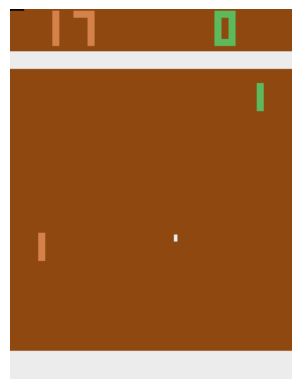

In [9]:
env.watch(
    RandomPolicy(env.get_action_space()),
    display,
    steps=320,
    action1=RIGHT,
    action2=LEFT,
    preprocess_fn=preprocess_batch,
    device=device,
)

## Preprocessing

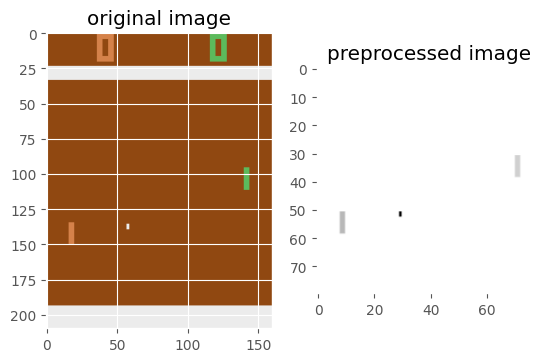

In [10]:
import matplotlib
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
state = env.reset()[0]
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _, _ = env.step(1)

plt.subplot(1, 2, 1)
plt.imshow(frame)
plt.title("original image")

plt.subplot(1, 2, 2)
plt.title("preprocessed image")

# 80 x 80 black and white image
preprocessed_frame = preprocess(frame)
plt.imshow(preprocessed_frame, cmap="Greys")
plt.show()

## Model

In [11]:
from model import FCBody, Conv2DBody
import torch.nn as nn

in_channels = 2
h_channels = 4
out_channels = 16
kernel_size = 6
h_stride = 2
a_stride = 4
h_activation = nn.ReLU()
a_activation = nn.ReLU()
h_bias = False
a_bias = True

state_size = out_channels * 9 * 9
hidden_size = 256
action_size = 1


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # input 80x80x2
        self.conv2dBody = Conv2DBody(
            in_channels=in_channels,
            h_channels=h_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            a_stride=a_stride,
            h_stride=h_stride,
            h_activation=h_activation,
            a_activation=a_activation,
            h_bias=h_bias,
            a_bias=a_bias,
        )
        # input 9x9x16
        self.fcBody = FCBody(
            s_size=state_size,
            a_size=action_size,
            h_size=hidden_size,
            h_activation=nn.ReLU(),
            a_activation=nn.Sigmoid(),
        )

    def forward(self, state):
        x = self.conv2dBody(state)
        x = self.fcBody(x)
        return x


model = Model().to(device)

## Rollout
Before we start the training, we need to collect samples. To make things efficient we use parallelized environments to collect multiple examples at once

In [12]:
from env import ParallelGym

parallelEnv = ParallelGym(name="pong", n_envs=16)

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [13]:
from policy import PPOParallelPolicy

policy = PPOParallelPolicy(model, device)

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


## Train

In [14]:
import torch.optim as optim
from train import PPOParallelTrainer
from torch.optim.lr_scheduler import ReduceLROnPlateau

max_steps_per_episode = 320
gamma = 0.99
print_every = 100
target_score = 10
n_episodes = 1_000
lr = 5e-3


optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(
    optimizer, mode="max", patience=200, factor=0.5
)

trainer = PPOParallelTrainer(
    policy=policy,
    environment=parallelEnv,
    optimizer=optimizer,
    scheduler=scheduler,
    max_steps_per_episode=max_steps_per_episode,
    gamma=gamma,
    target_score=target_score,
    print_every=print_every,
    preprocess_state_fn=preprocess_batch,
    device=device,
)

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [15]:
beta = 0.01
beta_decay = 0.9995
ppo_epoch = 4
epsilon = 0.1
epsilon_decay = 0.9995

scores = trainer.train(
    n_episodes,
    action1=RIGHT,
    action2=LEFT,
    beta=beta,
    beta_decay=beta_decay,
    future_rewards_only=True,
    normalize_rewards=True,
    ppo_epoch=ppo_epoch,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
)

Episode 100	Average Score: -8.72	Learning Rate: 0.005000


Episode 200	Average Score: -6.20	Learning Rate: 0.005000


Episode 300	Average Score: -6.05	Learning Rate: 0.005000


Episode 400	Average Score: -5.78	Learning Rate: 0.005000


Episode 500	Average Score: -5.87	Learning Rate: 0.005000


Episode 600	Average Score: -5.77	Learning Rate: 0.005000


Episode 700	Average Score: -5.45	Learning Rate: 0.005000


Episode 800	Average Score: -5.60	Learning Rate: 0.005000


Episode 900	Average Score: -5.41	Learning Rate: 0.005000


Episode 1000	Average Score: -5.45	Learning Rate: 0.005000


In [16]:
trainer.evaluate(5, action1=RIGHT, action2=LEFT)

Evaluation: Average reward over 5 episodes: -85.20


-85.2

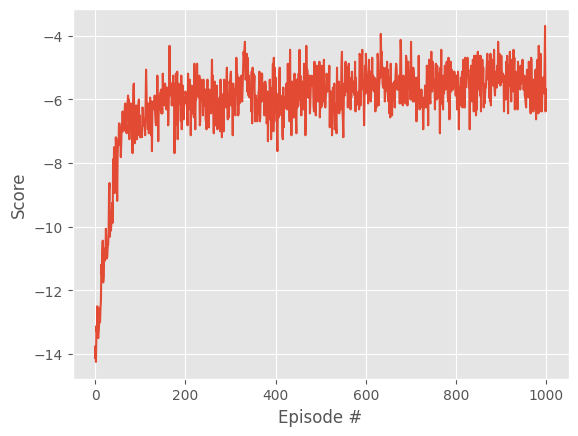

In [17]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel("Score")
plt.xlabel("Episode #")
plt.show()

## Save the agent

In [18]:
import torch

# Define the path where you want to save the model
model_path = "./checkpoints/reinforce_ppo_policy_cartpole.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), model_path)

## Watch a Smart Agent

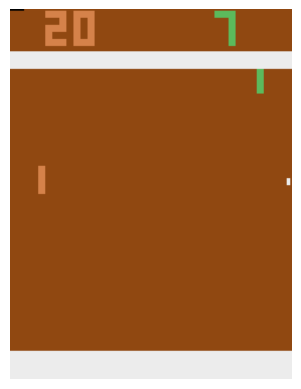

In [19]:
env.watch(
    policy,
    display,
    steps=1000,
    action1=RIGHT,
    action2=LEFT,
    preprocess_fn=preprocess_batch,
    device=device,
)